In [212]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import shutil
import datetime

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(''))+'/wfdb-python')
import wfdb
from wfdb import processing

import copy

import re

In [142]:
import boto3
from sagemaker.tensorflow import TensorFlowPredictor
import sagemaker

region = boto3.Session().region_name
bucket = 'sndv.datastorage'
prefix = 'cardio/database/mc100'
session = boto3.Session(profile_name = 'northstar')
sagemaker_session = sagemaker.Session(session)
tuner_predictor = TensorFlowPredictor('hp-tf-2020-02-05',  sagemaker_session = sagemaker_session)


In [85]:
#MC100 데이터와 physionet 데이터와 차이 알아볼 것 
# ---- 수정 -------


PATH_MC100 = '/home/nsc/seers/cardio/database/mc100/'
PATH_TARGET = PATH_MC100
TARGET_FS = 250
TARGET_TIME = 10 # 10 second

ARRHYTHMIAS_NAME_1 = ['Asystole', 
                      'Bradycardia', 
                      'Tachycardia', 
                      'Ventricular_Tachycardia', 
                      'Ventricular_Flutter_Fib'
                     ]
ARRHYTHMIAS_NAME_2 = ['ASYSTOLE', 
                      'BRADY', 
                      'TACHY', 
                      'V-TACH', 
                      'V-FIB/TACH'
                     ]
ARRHYTHMIAS_NAME_2TO1 = dict(zip(ARRHYTHMIAS_NAME_2, ARRHYTHMIAS_NAME_1))# --> dict 만듬 앞에 것이 key 뒤에 것이 value 
ARRHYTHMIAS_NAME_1TO2 = dict(zip(ARRHYTHMIAS_NAME_1, ARRHYTHMIAS_NAME_2))
dic_list_true = {}
dic_list_false = {}
for arrhythmias in ARRHYTHMIAS_NAME_1: # 정보를 담을 list 초기화 
    dic_list_true[arrhythmias] = []
    dic_list_false[arrhythmias] = []

In [3]:
def _download_dir(client, resource, dist, local='/tmp', bucket='your_bucket'):
    paginator = client.get_paginator('list_objects')
    for result in paginator.paginate(Bucket=bucket, Delimiter='/', Prefix=dist):
        if result.get('CommonPrefixes') is not None:
            for subdir in result.get('CommonPrefixes'):
                _download_dir(client, resource, subdir.get('Prefix'), local, bucket)
        for file in result.get('Contents', []):
            dest_pathname = os.path.join(local, file.get('Key'))
            if not os.path.exists(os.path.dirname(dest_pathname)):
                os.makedirs(os.path.dirname(dest_pathname))
            resource.meta.client.download_file(bucket, file.get('Key'), dest_pathname)

def download_dir(bucket, dist, local='/tmp'):
    client = session.client('s3')
    resource = session.resource('s3')
    _download_dir(client, resource, dist, local, bucket)
    
    

In [114]:
import dbcontrol
import importlib

sys.path.append(os.path.dirname(os.path.abspath(''))+'/mc100')

importlib.reload(dbcontrol)

query = """
select "measurementId","measurementCode"  from tb_measurement where "pridictStatus" = 'false'
"""
list_record = dbcontrol.sendquery(query, True , False)


[349]


In [15]:
def arrhythmias_name(comment):  # 들어온 ASYSTOLE 과 같은 형태로 이루어잔 2버전을 1버전으로 변환해주는 함수 
    for name in ARRHYTHMIAS_NAME_2:
        if name in comment: 
            return ARRHYTHMIAS_NAME_2TO1[name]
    return None

In [82]:
# # print(type(record['measurementCode']))

# for a,b in enumerate(list_record['measurementCode']):
#     print(b)

SN191018MC100_P007
SN191018MC100_P006
SN191016MC100_P005
SN191016MC100_P004
SN191016MC100_P003
SN191016MC100_P002
SN191016MC100_P001
NSTest


In [99]:
import numpy as np
from scipy import signal

In [96]:
def resample_sig(x, fs, fs_target): # target_fs -> 250, fs -> 256
    """
    Resample a signal to a different frequency.

    Parameters
    ----------
    x : numpy array
        Array containing the signal
    fs : int, or float
        The original sampling frequency
    fs_target : int, or float
        The target frequency

    Returns
    -------
    resampled_x : numpy array
        Array of the resampled signal values
    resampled_t : numpy array
        Array of the resampled signal locations

    """
    t = np.arange(x.shape[0]).astype('float64') 

    if fs == fs_target:
        return x, t

    new_length = int(x.shape[0]*fs_target/fs)
    resampled_x, resampled_t = signal.resample(x, num=new_length, t=t)

    # assert resampled_x.shape == resampled_t.shape and resampled_x.shape[0] == new_length
    # assert np.all(np.diff(resampled_t) > 0)

    return resampled_x, resampled_t

In [97]:
def replace_nan(x): #결측값 대체 
    print(np.argwhere(np.isnan(x)))
    nan_list = np.argwhere(np.isnan(x)) # 결측값 위치 뽑아옴 
    for nan_p in nan_list: #해당 위치 
        if nan_p[0] == 0: #첫번째 결측값의 위치가 맨 처음 일떄 
            if np.isnan(x[nan_p[0]+1][nan_p[1]]): # 그리고 다음것도 결측값일때 
                print('start nan')
                x[nan_p[0]+1][nan_p[1]] = 0. # 다음걸 0으로 만들고 
            x[nan_p[0]][nan_p[1]] = x[nan_p[0]+1][nan_p[1]] # 다음 값으로 대체 
        else: # 결측값의 부분이 처음이 아닐땐 이전 값으로 대체 
            x[nan_p[0]][nan_p[1]] = x[nan_p[0]-1][nan_p[1]]
    print(np.argwhere(np.isnan(x)))
    

In [162]:
def minmaxscalining(data):
    temp = (data-min(data))/(max(data) - min(data))
    temp = temp.reshape(1,-1,1)
    return temp
    

In [257]:
#['second', 'class', 'classNumber', 'beatNumber']

print('target record number : ', len(list_record['measurementCode']) )  # mc100 하위 디렉토리들 
for num, record in enumerate(list_record['measurementCode']):
    #if num < 7 : continue
    
    download_dir(bucket,os.path.join(prefix,record).replace('\\','/'), local='/home/nsc/seers/')
    
    PATH_RECORD = os.path.join(PATH_TARGET, record)
    file_record = os.path.join(PATH_RECORD ,record) #path_target은 mc100 임 거기다가
    # 레코드에 레코드 하면 해당 레코드에 해당하는 atr her ecg를 확장자만 바꾸면 접근할 수 있음 
    # ㅇㅋ 위에 file_record 로 wfdb 만드니까 위에서 이미 다운 받아놔야함 
    
    annotation = wfdb.rdann(file_record, 'atr') 
    print ('%d. read record : %s - sample : %d' % (num+1, file_record, len(annotation.sample)))
#     
    for idx, sample in enumerate(annotation.sample): # 하나로 통으로 된 곳에서 10초 단위로 짤라야하니까 
        #if idx < 12 : continue
        if annotation.symbol[idx] not in ['V', 'F']: # 해당 비트를 확인하는 거다리 ~ 
            continue # v나 f가 아니면 필요 없음 
       
    
        # ----------------------------------------------
        # annotation is alarm center
        # ----------------------------------------------
       
        
        record_10s_sampfrom = int(sample - annotation.fs * (TARGET_TIME/2)) # Target_time -> 10 
        # 5초를 구하려면 프레임 곱해줘야 5초치의 분량이 나오지  
        if record_10s_sampfrom < 0: # 0보다 작으면 0부터 보여주고 
            record_10s_sampfrom = 0
            
        record_10s_sampto = int(sample + annotation.fs * (TARGET_TIME/2)) # 그 다음 5초 분량 
        if record_10s_sampto < annotation.fs * TARGET_TIME: # 만약 5초를 더한 분량이 10초 분량보다 작다면 
            # 5초 이전 분량의 값이었을 것임 5초 이전의 분량은 모두 0에서 시작하니 마지막을 10으로 해주는 것 
            record_10s_sampto = int(annotation.fs * TARGET_TIME) # 예를 들어 포인트 기준 +- 5초니까
            # 5초 이전에 값을 할땐 0부터 하니 그냥 목적지도 해주는건듯 
                                      
        record_10s_ii_center = wfdb.rdrecord(file_record, 
                                   sampfrom = record_10s_sampfrom,
                                   sampto = record_10s_sampto) # to 는 목적지
        
        
        
        if record_10s_ii_center.fmt is None or record_10s_ii.adc_gain is None: 
            print ('  ** none data ')
            continue
        if record_10s_ii_center.fmt[0] is None or record_10s_ii.adc_gain[0] is None:
            print ('  ** none data ')
            continue
        if np.all(np.isnan(record_10s_ii_center.p_signal)):
            print ('  ** all data is nan')
            continue
        if np.all(record_10s_ii_center.p_signal == 0.):
            print ('  ** all data is 0.')
            continue
                
        d = record_10s_ii_center.base_date
        t = record_10s_ii_center.base_time
        dt = datetime.datetime.combine(d, t)
        dt2 = dt + datetime.timedelta(seconds=record_10s_sampfrom/annotation.fs)
        
        if np.isnan(record_10s_ii_center.p_signal).any(): # 결측값이 있다면 
            replace_nan(record_10s_ii_center.p_signal)
        
        
        # print(record_10s_ii.p_signal.shape)
        # resampled_x, resampled_t = processing.resample_sig(record_10s_ii.p_signal, record_10s_ii.fs, TARGET_FS)
        resampled_x, resampled_t = resample_sig(record_10s_ii_center.p_signal, record_10s_ii_center.fs, TARGET_FS)
        
        if np.all(np.isnan(resampled_x)):
            print ('  ** all resampled data is nan')
            wfdb.plot_wfdb(record=record_10s_ii_center, title=str_title, time_units='seconds')
            display(record_10s_ii_center.__dict__)     
            raise
            continue
        
        # resampled data로 대체 
        record_10s_ii_center.fs = TARGET_FS # 256 -> 250 
        record_10s_ii_center.sig_len = resampled_x.shape[0] # 2500
        record_10s_ii_center.p_signal = resampled_x 
        record_10s_ii_center.record_name = sample_name
        record_10s_ii_center.base_date = dt2.date()
        record_10s_ii_center.base_time = dt2.time()
        record_10s_ii_center.base_datetime = dt2
        record_10s_ii_center.fmt = ['16'] 

        
        
#         # ----------------------------------------------
#         # annotation is alarm right end
#         # ----------------------------------------------
        
        record_10s_sampfrom = int(sample - annotation.fs * TARGET_TIME) # 이건 튄 부분이 마지막에 위치하는 것임 
        if record_10s_sampfrom < 0: # 만약 10 초 분량 만큼 앞으로 갔는데 0보다 작으면 즉 10초 보다 전에 튀었으면 
            record_10s_sampfrom = 0 # 시작이 0 
            
        record_10s_sampto = sample # 현재 위치가 곧 마지막이지 
        if record_10s_sampto < annotation.fs * TARGET_TIME: # 이것또한 만약에 
            # 현재 위치가 10초 보다 작다면 현재 위치 말고 10초까지로 보여줌 
            record_10s_sampto = int(annotation.fs * TARGET_TIME)
                                      
        record_10s_ii_end = wfdb.rdrecord(file_record, 
                                   sampfrom = record_10s_sampfrom,
                                   sampto = record_10s_sampto)  # 기존 레코드에서 가져오는거지 원하는 만큼
        
        
        #wfdb.plot_wfdb(record=record_10s, title=str_title, time_units='seconds')
            
        if record_10s_ii_end.fmt is None or record_10s_ii_end.adc_gain is None: # 위와 동 
            print ('  ** none data ')
            continue
        if record_10s_ii_end.fmt[0] is None or record_10s_ii_end.adc_gain[0] is None:
            print ('  ** none data ')
            continue
        if np.all(np.isnan(record_10s_ii_end.p_signal)):
            print ('  ** all data is nan')
            continue
        if np.all(record_10s_ii_end.p_signal == 0.):
            print ('  ** all data is 0.')
            continue
                
        d = record_10s_ii_end.base_date # 위와 동 
        t = record_10s_ii_end.base_time
        dt = datetime.datetime.combine(d, t)
        dt2 = dt + datetime.timedelta(seconds=record_10s_sampfrom/annotation.fs)
        
        if np.isnan(record_10s_ii_end.p_signal).any(): # 위와 동 
            replace_nan(record_10s_ii_end.p_signal)
        
        # print(record_10s_ii.p_signal.shape)
        # resampled_x, resampled_t = processing.resample_sig(record_10s_ii.p_signal, record_10s_ii.fs, TARGET_FS)
        resampled_x, resampled_t = resample_sig(record_10s_ii_end.p_signal, record_10s_ii_end.fs, TARGET_FS)
        # 여기도 위와 동임 256짜리였는데 250짜리로 바꿔줌 왜일까 
        
        if np.all(np.isnan(resampled_x)):
            print ('  ** all resampled data is nan')
            wfdb.plot_wfdb(record=record_10s_ii_end, title=str_title, time_units='seconds')
            display(record_10s_ii_end.__dict__)     
            raise
            continue
            
        # re setting 
        record_10s_ii_end.fs = TARGET_FS 
        record_10s_ii_end.sig_len = resampled_x.shape[0]
        record_10s_ii_end.p_signal = resampled_x       
        record_10s_ii_end.record_name = sample_name
        record_10s_ii_end.base_date = dt2.date()
        record_10s_ii_end.base_time = dt2.time()
        record_10s_ii_end.base_datetime = dt2
        record_10s_ii_end.fmt = ['16'] 

        
        ############## 추론 ###############
        
        
        
        result = tuner_predictor.predict(minmaxscalining(record_10s_ii_center.p_signal))
        result2 = tuner_predictor.predict(minmaxscalining(record_10s_ii_end.p_signal))
        
#         print(result)
#         print(result2)
        
        print("{}-{}".format(datetime.timedelta(seconds=sample/annotation.fs),sample))
        print(datetime.timedelta(seconds=sample/annotation.fs).seconds)
        print(datetime.timedelta(seconds=sample/annotation.fs) * annotation.fs)
        
         ############# 추론 결과 저장 #########
        
        query = """
        insert into tb_inference("measurementCode","inferenceTime","bit_time","inferenceResult","sendStatus","checkLocation") 
        values('{}','{}','{}','{}','{}','{}')
        """.format(record,datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                   "{}({})".format(str(datetime.timedelta(seconds=sample/annotation.fs)) , sample) 
                   ,np.argmax(result['predictions'][0]) == 1,False, "center")
        
        dbcontrol.sendquery(query,False)
        
        query = """
        insert into tb_inference("measurementCode","inferenceTime","bit_time","inferenceResult","sendStatus","checkLocation") 
        values('{}','{}','{}','{}','{}','{}')
        """.format(record,datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                   "{}({})".format(str(datetime.timedelta(seconds=sample/annotation.fs)), sample),
                   np.argmax(result2['predictions'][0]) == 1,False , "end")
        
        dbcontrol.sendquery(query,False)
                   
        
    ############# 로컬에서 삭제 #######
    shutil.rmtree(PATH_RECORD)
    ############# 디비 수정 predict 컬럼 #######
    # 레코드 하나 수행 마치고 해야함 
    query = """
    update tb_measurement set "pridictStatus" = true where "measurementCode" = '{}'
    """.format(record)
    dbcontrol.sendquery(query,False)
    
        
        

target record number :  8
1. read record : /home/nsc/seers/cardio/database/mc100/SN191018MC100_P007\SN191018MC100_P007 - sample : 2654
{'predictions': [[0.477167, 0.522833]]}
{'predictions': [[0.529622, 0.470378]]}
0:00:12.437500-3184
12
0:53:04

        insert into tb_inference("measurementCode","inferenceTime","bit_time","inferenceResult","sendStatus","checkLocation") 
        values('SN191018MC100_P007','2020-02-05 17:27:48','0:00:12.437500(3184)','True','False','center')
        

        insert into tb_inference("measurementCode","inferenceTime","bit_time","inferenceResult","sendStatus","checkLocation") 
        values('SN191018MC100_P007','2020-02-05 17:27:48','0:00:12.437500(3184)','False','False','end')
        
{'predictions': [[0.695412, 0.304588]]}
{'predictions': [[0.657334, 0.342666]]}
0:00:19.687500-5040
19
1:24:00

        insert into tb_inference("measurementCode","inferenceTime","bit_time","inferenceResult","sendStatus","checkLocation") 
        values('SN191018MC100_P

KeyboardInterrupt: 

In [276]:
def view(id):
    query = """
    select * from tb_inference where id = {}
    """.format(id)
    temp = dbcontrol.sendquery(query, True)
    
    print(temp)
    record = temp['measurementCode'][0]
    regex ='\(([0-9\\.]+)\)$'
    comp = re.compile(regex)
    sample = int(comp.findall(temp['bit_time'][0])[0])

    
    download_dir(bucket,os.path.join(prefix,record).replace('\\','/'), local='/home/nsc/seers/')
    
    PATH_RECORD = os.path.join(PATH_TARGET, record)
    file_record = os.path.join(PATH_RECORD ,record)
    annotation = wfdb.rdann(file_record, 'atr') 
    
    
    sample_ann = copy.deepcopy(annotation)
    sample_ann.symbol = []
    sample_ann.aux_note = []
    sample_ann.sample = np.array([0], dtype=int)
    sample_ann.ann_len = 1
    sample_ann.fs = TARGET_FS
    sample_ann.subtype = None
    sample_ann.chan = np.array([0], dtype=int)
    sample_ann.num = None
    
    if temp['checkLocation'][0] == 'end':
        record_10s_sampfrom = int(sample - annotation.fs * TARGET_TIME) # 이건 튄 부분이 마지막에 위치하는 것임 
        if record_10s_sampfrom < 0: # 만약 10 초 분량 만큼 앞으로 갔는데 0보다 작으면 즉 10초 보다 전에 튀었으면 
            record_10s_sampfrom = 0 # 시작이 0 

        record_10s_sampto = sample # 현재 위치가 곧 마지막이지 
        if record_10s_sampto < annotation.fs * TARGET_TIME: # 이것또한 만약에 
            record_10s_sampto = int(annotation.fs * TARGET_TIME)
            
    elif temp['checkLocation'][0] == 'center':
        record_10s_sampfrom = int(sample - annotation.fs * (TARGET_TIME/2))    
        if record_10s_sampfrom < 0: 
            record_10s_sampfrom = 0
            
        record_10s_sampto = int(sample + annotation.fs * (TARGET_TIME/2)) # 그 다음 5초 분량 
        if record_10s_sampto < annotation.fs * TARGET_TIME: # 만약 5초를 더한 분량이 10초 분량보다 작다면 
            record_10s_sampto = int(annotation.fs * TARGET_TIME) # 예를 들어 포인트 기준 +- 5초니까
            
#     sample_ann.symbol = [annotation.symbol[idx]]
    ann_point = int((sample - record_10s_sampfrom) / annotation.fs * TARGET_FS - 1)
    sample_ann.sample = np.array([ann_point], dtype=int)
    
    
    record_10s = wfdb.rdrecord(file_record, sampfrom = record_10s_sampfrom, sampto = record_10s_sampto)
    wfdb.plot_wfdb(record=record_10s, title=temp['bit_time'][0], time_units='seconds', annotation = sample_ann)

   id     measurementCode        inferenceTime                bit_time  \
0  99  SN191018MC100_P007  2020-02-05 17:27:58  0:29:05.828125(446932)   

  inferenceResult sendStatus checkLocation  
0            True      False        center  


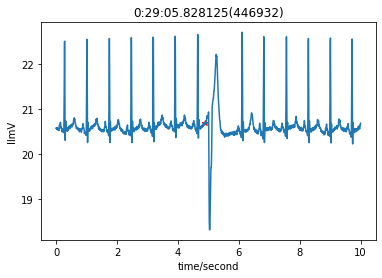

In [278]:
view(99)

In [19]:
sys.path.append(os.path.dirname(os.path.abspath(''))+'/mc100')
import dbcontrol
import importlib
importlib.reload(dbcontrol)

query = """
select "measurementCode", "storePath" from tb_measurement where "pridictStatus" = 'false'
"""
infomation = dbcontrol.sendquery(query, True , True)

In [50]:
infomation
# infomation.columns
# print(infomation.shape)

# print(      os.path.join(infomation['storePath'][0],'hbclass.txt').replace('\\','/')     )

os.path.join(prefix,infomation['measurementCode'][0],'hbclass.txt').replace('\\','/')

'cardio/database/mc1003/SN191018MC100_P007/hbclass.txt'

In [115]:
aa = "aa"
ss = "bb"
print(aa+ss)

aabb


In [60]:
os.path.join(prefix,infomation['measurementCode'][0]).replace('\\','/')

'cardio/database/mc1003/SN191018MC100_P007'

In [71]:
download_dir(bucket,os.path.join(prefix,infomation['measurementCode'][0]).replace('\\','/'), local='/home/nsc/seers/')